Type f to use Gauss-Seidel´s algorithm with a for loop, and c to use checkerboard method:f
It took: 9.477745310465496 minutes to run


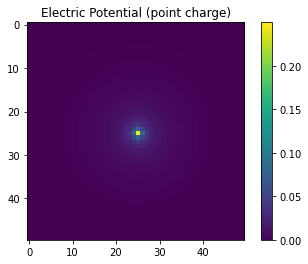

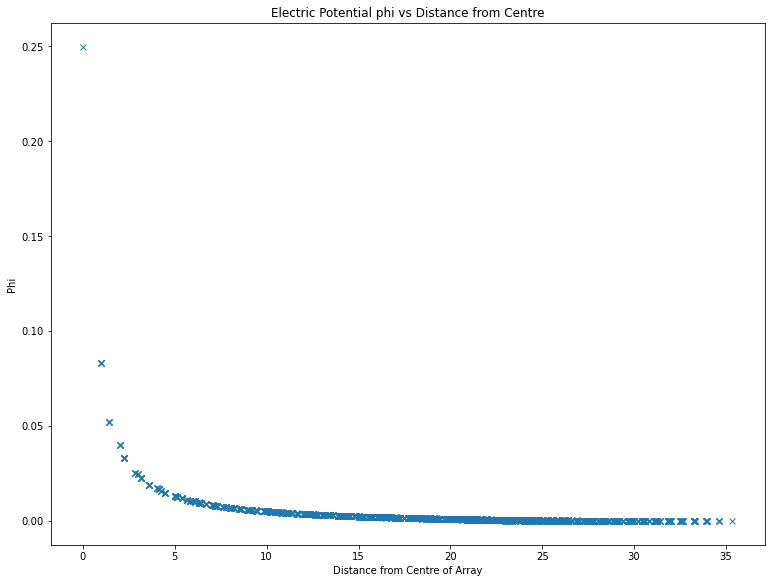

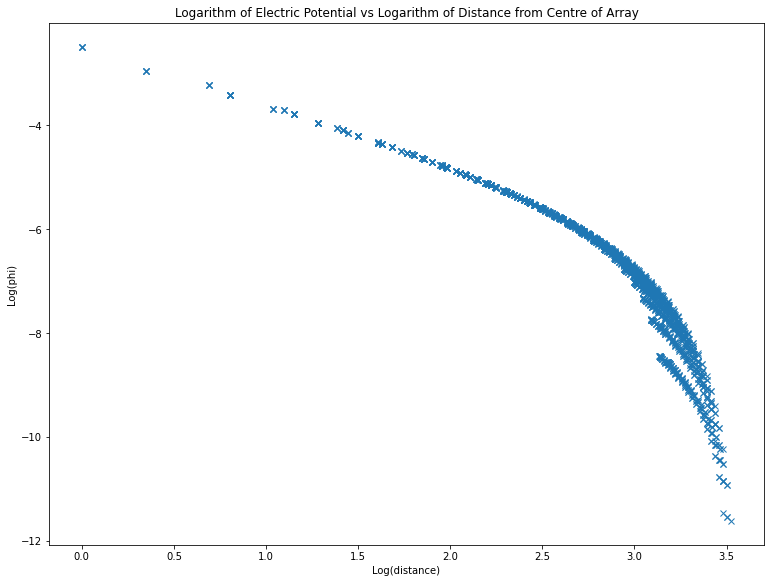

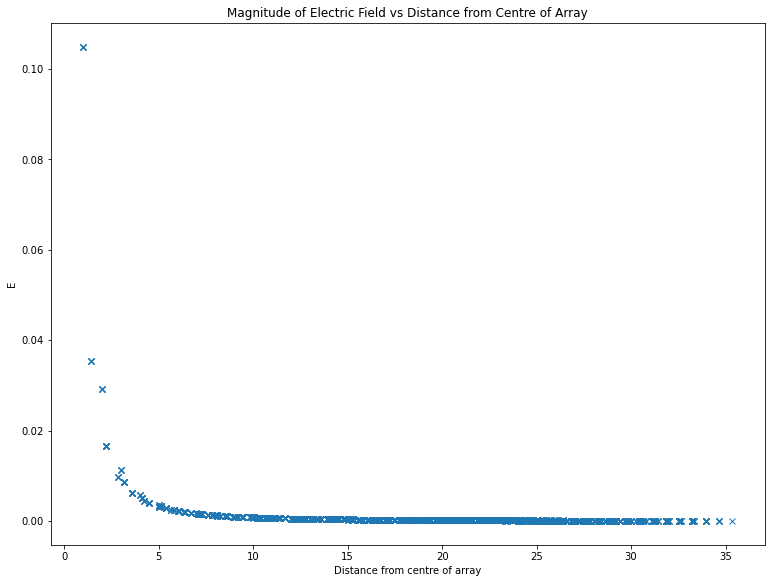

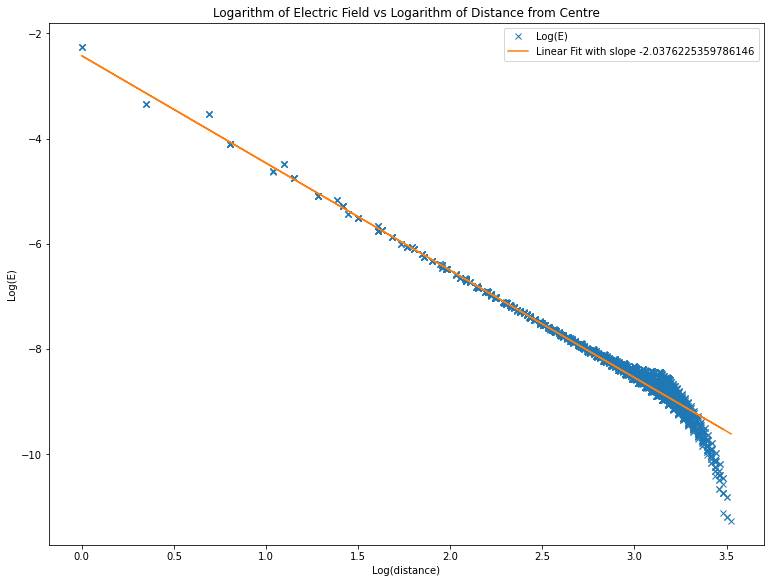

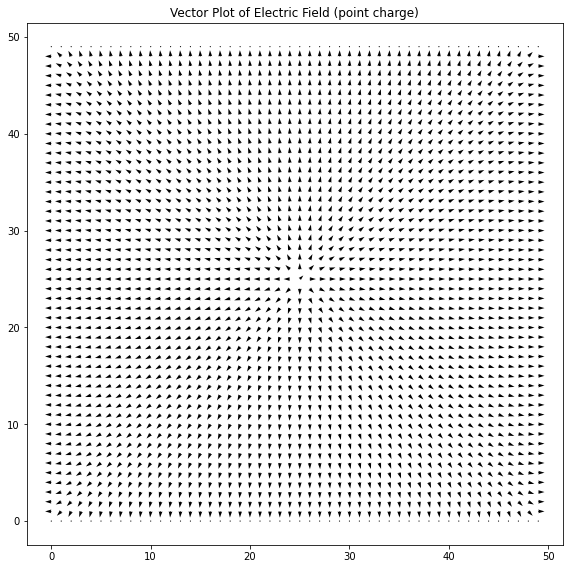

In [4]:
import matplotlib
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import time
import scipy as sp
from scipy import ndimage

start_time=time.time()

#Number of Montecarlo sweeps for calculation
sweeps = 20000

N=50

dt=1
dx=1
M=0.1
a=0.1
k=0.1


def Efield(phi,coord):
    return -(1/(2*dx))*(np.roll(phi,-1,axis=coord) - np.roll(phi,1,axis=coord))


def GaussSeidelForloop(phi):
    
    for i in range(1,N-1):
        for j in range(1,N-1):
            for k in range(1,N-1):
                   phi[i,j,k] = 1/6*(phi[(i+1)%N,j,k] + phi[(i-1)%N,j,k] + phi[i,(j+1)%N,k] + phi[i,(j-1)%N,k]
                                    + phi[i,j,(k+1)%N] + phi[i,j,(k-1)%N] + rho[i,j,k])

    
    return phi

def GaussSeidel(phi):            
    
    phi2=np.copy(phi)*chessboard1
    phi1=np.copy(phi)*chessboard2
  
    
    phi1 = (1/6)*(np.roll(phi2,1,axis=0) + np.roll(phi2,-1,axis=0) + np.roll(phi2,1,axis=1) 
                  + np.roll(phi2,-1,axis=1) + np.roll(phi2,1,axis=2) + np.roll(phi2,-1,axis=2) + rho*chessboard1)
    
    phi1[:,:,N-1] = 0
    phi1[:,N-1,:] = 0
    phi1[N-1,:,:] = 0
    phi1[:,:,0] = 0
    phi1[:,0,:] = 0
    phi1[0,:,:] = 0
    
    phi =  phi1 + (1/6)*(np.roll(phi1,1,axis=0) + np.roll(phi1,-1,axis=0) + np.roll(phi1,1,axis=1) 
                  + np.roll(phi1,-1,axis=1) + np.roll(phi1,1,axis=2) + np.roll(phi1,-1,axis=2) + rho*chessboard2)
    
    phi[:,:,N-1] = 0
    phi[:,N-1,:] = 0
    phi[N-1,:,:] = 0
    phi[:,:,0] = 0
    phi[:,0,:] = 0
    phi[0,:,:] = 0
    
    return phi 

phi = np.zeros((N,N,N))
prevphi = np.zeros((N,N,N))
rho = np.zeros((N,N,N))
rho[int(N/2),int(N/2),int(N/2)]=1

chessboard1 = np.sum(np.indices((N,N,N)),axis=0) % 2
chessboard2 = (np.sum(np.indices((N,N,N)),axis = 0) + np.ones((N,N,N))) % 2


algorithm=input("Type f to use Gauss-Seidel´s algorithm with a for loop, and c to use checkerboard method:" "")


if algorithm == "f":

    for i in range(sweeps):         
     
        phi=GaussSeidelForloop(phi)
        
        if np.sum(abs(prevphi-phi)) < 10**(-3):
            break

        prevphi=np.copy(phi)

elif algorithm == "c":
    
    for i in range(sweeps):         
     
        phi=GaussSeidel(phi)
        
        if np.sum(abs(prevphi-phi)) < 10**(-3):
            break

        prevphi=np.copy(phi)

else:
    
    print("You did not press f nor c, please try again.")  

im=plt.figure()
plt.imshow((phi[:,:,int(N/2)]))
plt.title("Electric Potential (point charge)")
plt.colorbar()

ex=Efield(phi,1)
ey=Efield(phi,0)
ez=Efield(phi,2)

magE=np.sqrt(ex[:,:,int(N/2)]**2 + ey[:,:,int(N/2)]**2 + ez[:,:,int(N/2)]**2)

plotphi=[]
plotdistE=[]
plotdist=[]
logplotphi=[]
logplotdist=[]
plotE=[]
logplotE=[]

    
dist=np.zeros((N,N))

for i in range(N):
    for j in range(N):
        dist[i,j]=np.sqrt(abs(int(N/2)-i)**2+abs(int(N/2)-j)**2)

        if dist[i,j] != 0:
            plotdistE.append(dist[i,j])
            plotE.append(magE[i,j])
            if phi[:,:,int(N/2)][i,j] != 0:
                logplotE.append(np.log(magE[i,j]))
                logplotphi.append(np.log(phi[:,:,int(N/2)][i,j]))
                logplotdist.append(np.log(dist[i,j]))
        plotdist.append(np.sqrt(abs(int(N/2)-i)**2+abs(int(N/2)-j)**2))
        plotphi.append(phi[:,:,int(N/2)][i,j])
     
linearfitE=[]
linearfitEdist=[]
for i in range(len(logplotE)):
    if logplotE[i]>-8:
        linearfitE.append(logplotE[i])
        linearfitEdist.append(logplotdist[i])   



if algorithm == "f":        
        
    data=np.vstack((phi.flatten(),ex.flatten(),ey.flatten(),ez.flatten())).T
    dataJacobi=pd.DataFrame(data)
    dataJacobi.to_csv('dataGaussSeidelForloopE.csv',index=False)
    
elif algorithm == "c":
    
    data=np.vstack((phi.flatten(),ex.flatten(),ey.flatten(),ez.flatten())).T
    dataJacobi=pd.DataFrame(data)
    dataJacobi.to_csv('dataGaussSeidelCheckerboardE.csv',index=False)

f = plt.figure(figsize=(12.8, 9.6));   
plt.plot(plotdist,plotphi,'x')
plt.title("Electric Potential phi vs Distance from Centre")
plt.xlabel("Distance from Centre of Array")
plt.ylabel("Phi")

    
g=plt.figure(figsize=(12.8, 9.6));
plt.plot(logplotdist,logplotphi,'x')
plt.title("Logarithm of Electric Potential vs Logarithm of Distance from Centre of Array")
plt.xlabel("Log(distance)")
plt.ylabel("Log(phi)")
      
e=plt.figure(figsize=(12.8, 9.6));
plt.plot(plotdistE,plotE,'x')
plt.title("Magnitude of Electric Field vs Distance from Centre of Array")
plt.xlabel("Distance from centre of array")
plt.ylabel("E")

linearfitlogE=np.polyfit(linearfitEdist,linearfitE,1)
linelogE=linearfitlogE[0]*np.array(logplotdist)+linearfitlogE[1]

loge,ax = plt.subplots(figsize=(12.8, 9.6));
ax.plot(logplotdist,logplotE,'x',label="Log(E)")
ax.plot(logplotdist,linelogE,label="Linear Fit with slope " + str(linearfitlogE[0]) )
leg = ax.legend()
plt.title("Logarithm of Electric Field vs Logarithm of Distance from Centre")
plt.xlabel("Log(distance)")
plt.ylabel("Log(E)")

for i in range(len(np.where(magE==0))):
    magE[np.where(magE==0)[i]]=1
    
v= plt.figure(figsize=(9.6, 9.6));        
xloc=np.arange(N)
yloc=np.arange(N)
plt.quiver(xloc, yloc, ex[:,:,int(N/2)]/magE, ey[:,:,int(N/2)]/magE)
plt.title("Vector Plot of Electric Field (point charge)")

print("It took: "+str((time.time()-start_time)/60)+" minutes to run")
